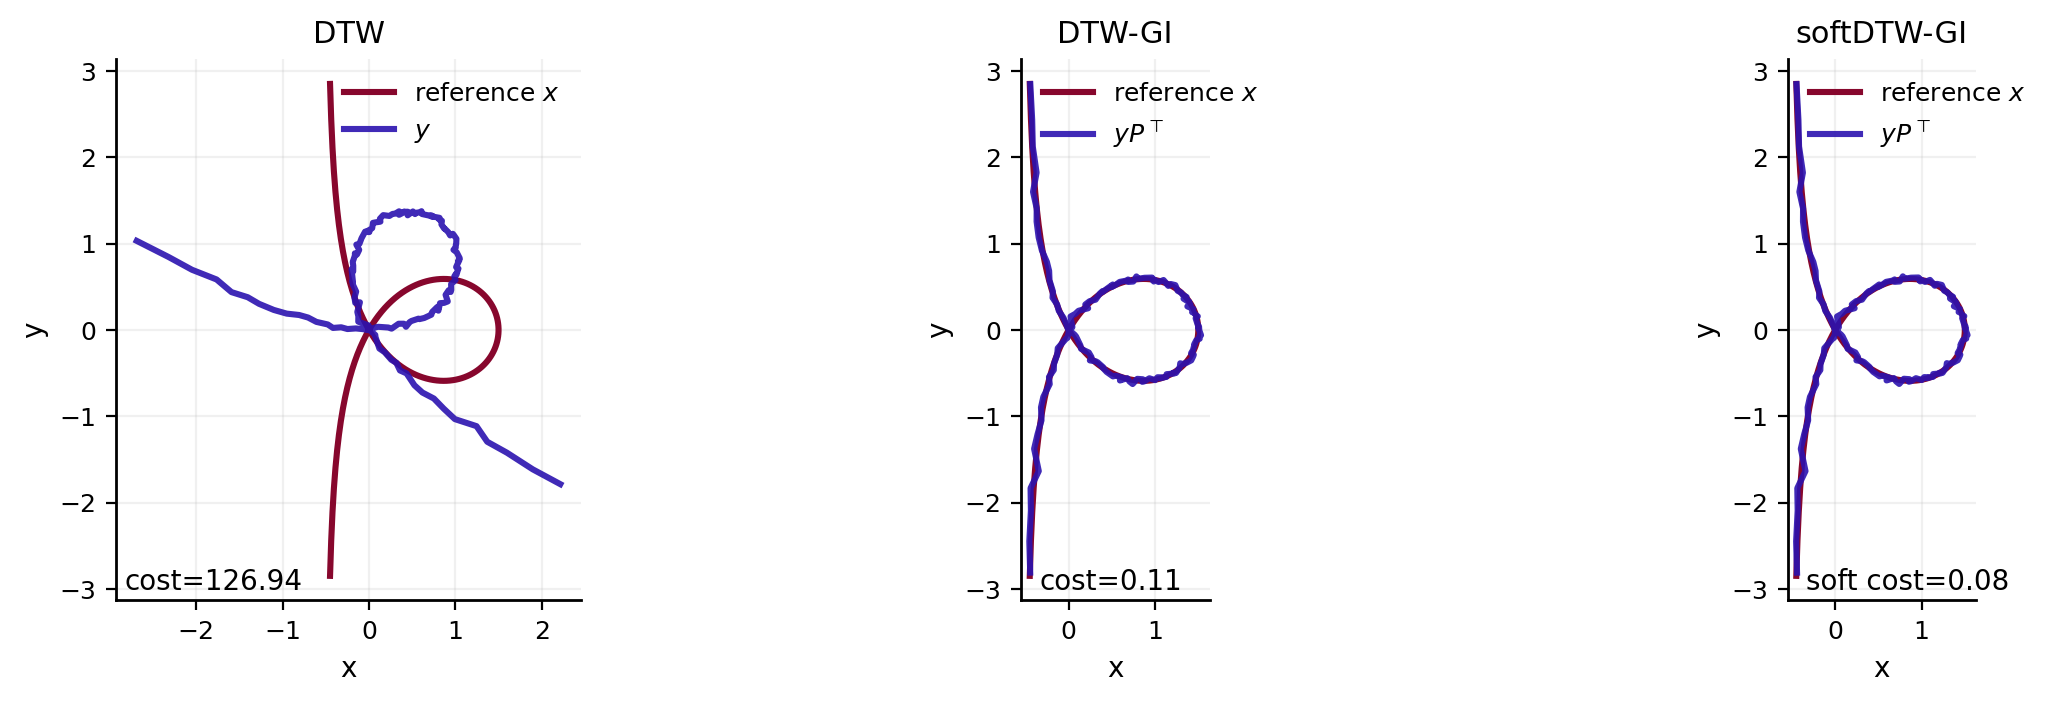

In [109]:
import numpy as np
import matplotlib.pyplot as plt


import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

from dtw_gi.dtw.backend import compute_dtw_path
from dtw_gi import dtw_gi, dtw_gi_multistart
from dtw_gi import soft_dtw_gi
from data import make_one_folium, get_rot2d



plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.0,
})



def plot_traj(ax, ts, *, label=None, lw=2.2, alpha=1.0, color=None):
    ax.plot(
        ts[:, 0],
        ts[:, 1],
        lw=lw,
        alpha=alpha,
        color=color,
        label=label,
    )


def plot_alignment_geometry_with_softdtw(
    *,
    T=140,
    noise_std=0.02,
    alpha=np.pi / 3,
    seed=0,
    backend="tslearn",
):
    rng = np.random.default_rng(seed)

    x = make_one_folium(sz=T, noise=0.0)
    R = get_rot2d(alpha)
    y = x @ R.T + noise_std * rng.standard_normal(x.shape)

    _, cost_dtw = compute_dtw_path(x, y, backend=backend) 



    res_gi = dtw_gi_multistart(
        x, y,
        max_iter=30,
        n_random_starts=5,
        seed=seed,
        backend=backend,
        verbose=False,
    )
    P_gi = res_gi.P
    yP = y @ P_gi.T
    yP_dtw = yP 



    res_soft = soft_dtw_gi(
        x, y,
        gamma=0.01,
        max_iter=150,
        lr=0.01,
        early_stopping_patience=10,
        verbose=False,
    )

    P_soft = res_soft.P
    yP_soft = y @ P_soft.T

    yP_soft_dtw = yP_soft 

    fig, axes = plt.subplots(1, 3, figsize=(11.5, 3.4), constrained_layout=True)

    for ax in axes:
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, alpha=0.18, linewidth=0.8)
        ax.set_xlabel("x")
        ax.set_ylabel("y")

    # DTW
    ax = axes[0]
    ax.set_title("DTW")
    plot_traj(ax, x, label ="reference $x$", color = "#87072d")
    plot_traj(ax, y, label =r"$y$", alpha=0.9, color = "#2b13af")
    ax.legend(frameon=False)
    ax.text(0.02, 0.02, f"cost={cost_dtw:.2f}", transform=ax.transAxes)

    # DTW-GI 
    ax = axes[1]
    ax.set_title("DTW-GI")
    plot_traj(ax, x, label ="reference $x$", color = "#87072d")
    plot_traj(ax, yP_dtw, label =r"$yP^\top$", alpha=0.9, color = "#2b13af")
    ax.legend(frameon=False)
    ax.text(
        0.1, 0.02,
        f"cost={res_gi.cost:.2f}",
        transform=ax.transAxes
    )

    # softDTW-GI 
    ax = axes[2]
    ax.set_title("softDTW-GI")
    plot_traj(ax, x, label ="reference $x$", color = "#87072d")
    plot_traj(ax, yP_soft_dtw, label =r"$yP^\top$", alpha=0.9, color= "#2b13af")
    ax.legend(frameon=False)
    ax.text(
        0.1, 0.02,
        f"soft cost={res_soft.cost:.2f}",
        transform=ax.transAxes
    )

    plt.show()


plot_alignment_geometry_with_softdtw(
    T=140,
    noise_std=0.02,
    alpha=np.pi / 3,
    seed=0,
    backend="tslearn",
)


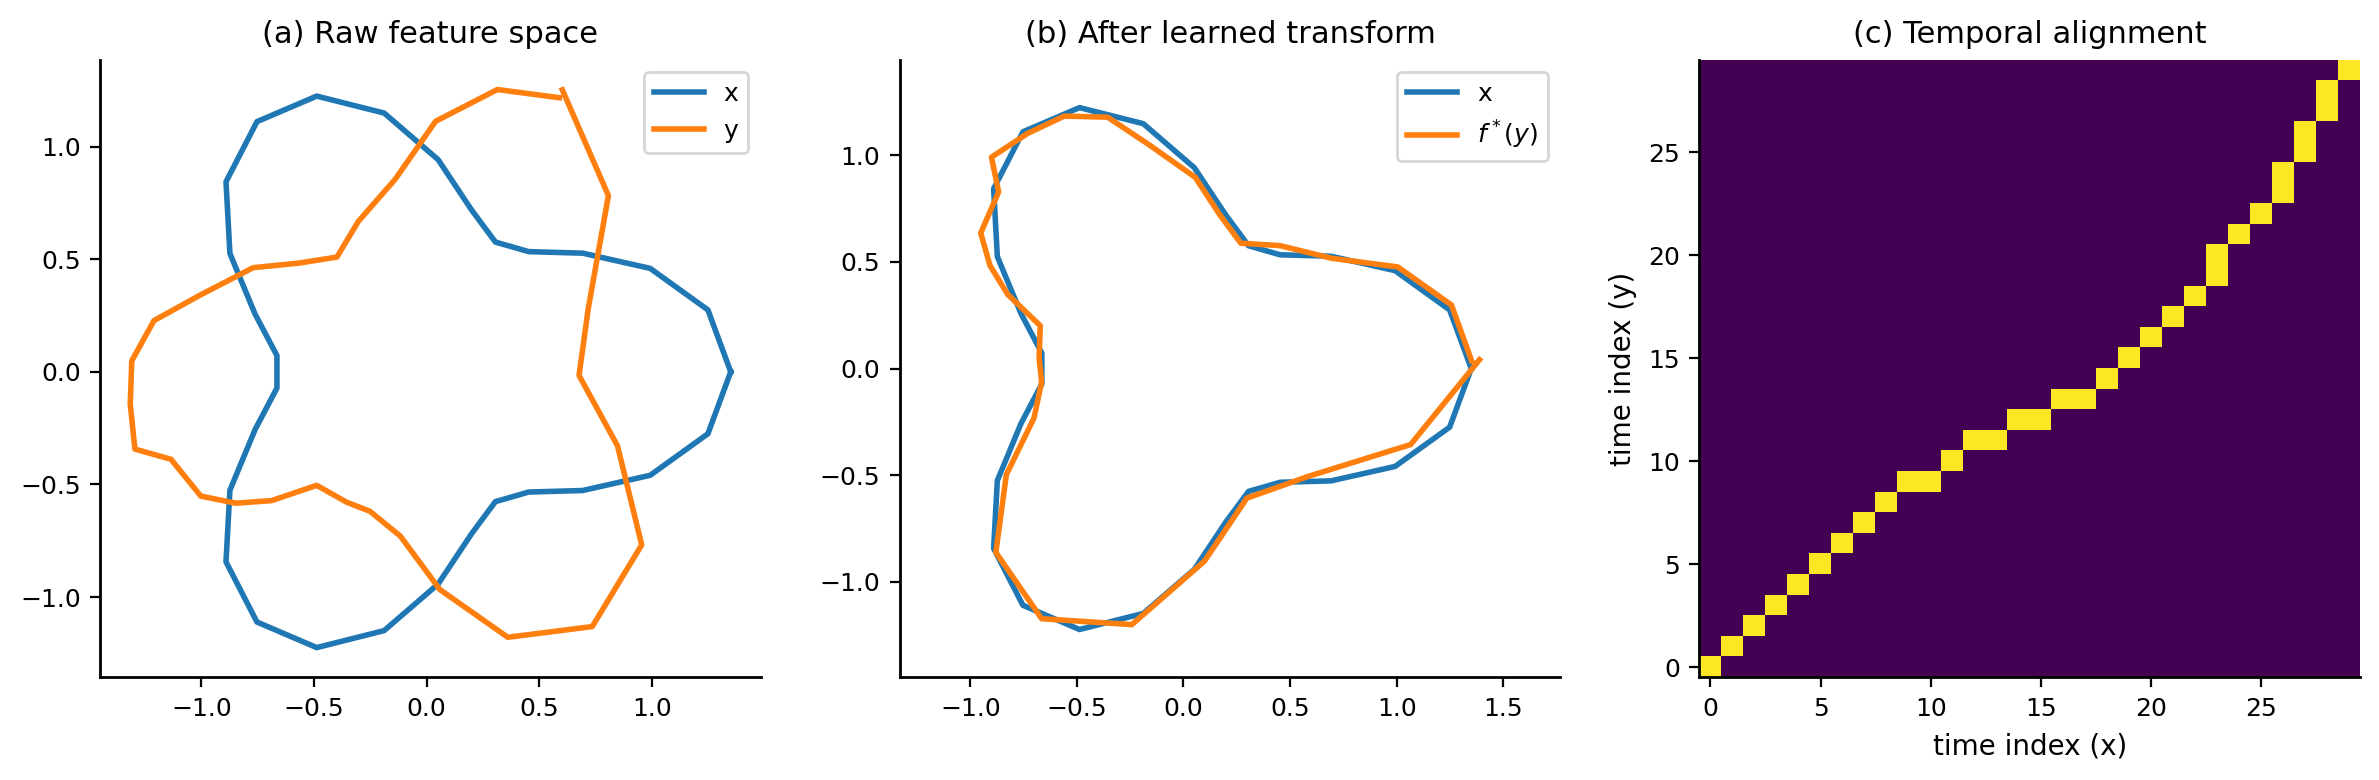

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from dtw_gi.dtw import path_to_W
from tslearn.metrics import dtw_path

plt.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.0,
})

T = 30
theta = np.linspace(0, 2*np.pi, T)

a, b, k = 1.0, 0.35, 3

r = a + b * np.cos(k * theta)

x = np.stack([
    r * np.cos(theta),
    r * np.sin(theta)
], axis=1)

s = np.linspace(0, 1, T)
tau = np.clip(s**1.3 + 0.08 * np.sin(2 * np.pi * s), 0, 1)

theta_tau = 2 * np.pi * tau
r_tau = a + b * np.cos(k * theta_tau)

y = np.stack([
    r_tau * np.cos(theta_tau),
    r_tau * np.sin(theta_tau)
], axis=1)

phi = np.pi / 2.8
R = np.array([
    [np.cos(phi), -np.sin(phi)],
    [np.sin(phi),  np.cos(phi)]
])

y = (R @ y.T).T + 0.02 * np.random.randn(*y.shape)

# --- run DTW-GI (your implementation) ---
# f_star: learned linear map (2x2)
# W: alignment matrix (Tx x Ty)

res = dtw_gi(x, y)   # returns BCDResult

P = res.P
path = res.path

# transformed series
y_aligned = (P @ y.T).T

# alignment matrix
W = path_to_W(path, len(x), len(y))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# (a) raw feature space
axes[0].plot(x[:,0], x[:,1], lw=2, label="x")
axes[0].plot(y[:,0], y[:,1], lw=2, label="y")
axes[0].set_title("(a) Raw feature space")
axes[0].axis("equal")
axes[0].legend()

# (b) after learned transform
axes[1].plot(x[:,0], x[:,1], lw=2, label="x")
axes[1].plot(y_aligned[:,0], y_aligned[:,1], lw=2, label=r"$f^*(y)$")
axes[1].set_title("(b) After learned transform")
axes[1].axis("equal")
axes[1].legend()

# (c) temporal alignment
axes[2].imshow(W, aspect="auto", origin="lower", cmap="viridis")
axes[2].set_title("(c) Temporal alignment")
axes[2].set_xlabel("time index (x)")
axes[2].set_ylabel("time index (y)")

plt.tight_layout()
plt.show()


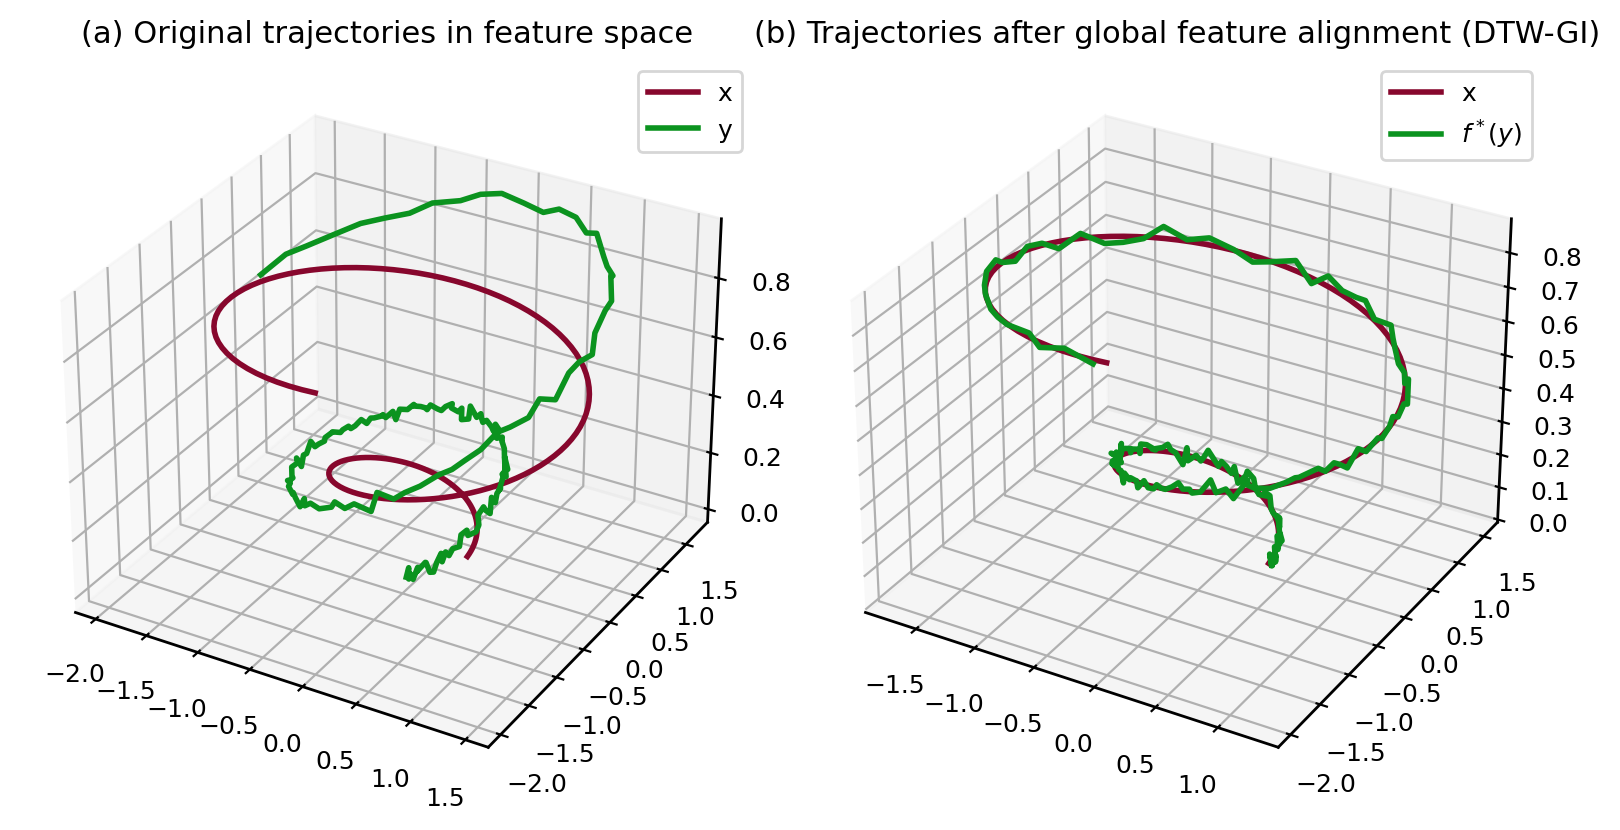

In [81]:
import numpy as np

T = 160
theta = np.linspace(0.2, 3.5 * np.pi, T)   # truncated, avoids origin singularity

a, b = 0.3, 0.15
c = 0.08

r = a + b * theta

x = np.stack([
    r * np.cos(theta),
    r * np.sin(theta),
    c * theta
], axis=1)


s = np.linspace(0, 1, T)

tau = np.clip(
    s**1.35 + 0.07 * np.sin(2 * np.pi * s),
    0, 1
)

theta_tau = 0.2 + tau * (3.5 * np.pi - 0.2)
r_tau = a + b * theta_tau


y = np.stack([
    r_tau * np.cos(theta_tau),
    r_tau * np.sin(theta_tau),
    c * theta_tau
], axis=1)


def random_rotation_3d(seed=0):
    rng = np.random.default_rng(seed)
    A = rng.normal(size=(3, 3))
    Q, _ = np.linalg.qr(A)
    return Q

R = random_rotation_3d(seed=42)

y = (R @ y.T).T + 0.015 * np.random.randn(*y.shape)


res = dtw_gi(x, y)

P = res.P
path = res.path

y_aligned = (P @ y.T).T
W = path_to_W(path, len(x), len(y))

# extract aligned pairs from DTW path
x_corr = np.array([x[i] for i, j in path])
y_corr = np.array([y[j] for i, j in path])

step = max(len(path) // 40, 1)   # about 30–40 lines
idx = np.arange(0, len(path), step)

x_corr = x_corr[idx]
y_corr = y_corr[idx]



from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection="3d")
ax1.plot(*x.T, lw=2, label="x", color= "#87072d")
ax1.plot(*y.T, lw=2, label="y", color =   "#0B931F")
ax1.set_title("(a) Original trajectories in feature space")
ax1.legend()

ax2 = fig.add_subplot(132, projection="3d")
ax2.plot(*x.T, lw=2, label="x", color = "#87072d")
ax2.plot(*y_aligned.T, lw=2, label=r"$f^*(y)$", color = "#0B931F")
ax2.set_title("(b) Trajectories after global feature alignment (DTW-GI)")
ax2.legend()



plt.tight_layout()
plt.show()


In [166]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Helpers
# ---------------------------
def path_to_pairs(path):
    # path is list[(i,j)] or np array shape (L,2)
    return list(map(tuple, path))

def plot_correspondences_2d(
    ax,
    X2,
    Y2,
    path,
    title,
    cmap_name="turbo",
    y_offset=None,
    line_alpha_same=0.75,
    line_alpha_diff=0.45,
    lw_same=1.25,
    lw_diff=1.0,
    s_point=35,
    s_ring=38,
    ring_lw=1.0,
    add_grid=True,
):
    """
    Plot X2 and Y2 (T x 2 each) with Y translated downward, then draw alignment lines.
    - Points are colored by time index (rainbow-like via cmap).
    - Dark rings show exact time-steps.
    - Lines: green if i==j else red.
    - Grid is drawn in the background (even though axes are hidden).
    """
    path = path_to_pairs(path)

    Tx = X2.shape[0]
    Ty = Y2.shape[0]

    # translate Y downward to separate the curves
    if y_offset is None:
        y_span = max(np.ptp(X2[:, 1]), np.ptp(Y2[:, 1]))
        y_offset = 1.35 * (y_span if y_span > 1e-9 else 1.0)

    Y2_shift = Y2.copy()
    Y2_shift[:, 1] -= y_offset

    # time colors
    cmap = plt.get_cmap(cmap_name)
    cx = np.linspace(0, 1, Tx)
    cy = np.linspace(0, 1, Ty)

    # ---- set limits early so grid can be placed nicely
    all_x = np.concatenate([X2[:, 0], Y2_shift[:, 0]])
    all_y = np.concatenate([X2[:, 1], Y2_shift[:, 1]])
    pad_x = 0.08 * (all_x.max() - all_x.min() + 1e-9)
    pad_y = 0.08 * (all_y.max() - all_y.min() + 1e-9)

    ax.set_xlim(all_x.min() - pad_x, all_x.max() + pad_x)
    ax.set_ylim(all_y.min() - pad_y, all_y.max() + pad_y)

    # ---- grid (background)
    if add_grid:
        ax.set_axisbelow(True)
        ax.grid(True, which="major", linewidth=0.6, alpha=0.25)
        ax.minorticks_on()
        ax.grid(True, which="minor", linewidth=0.4, alpha=0.12)

    # trajectories (thin)
    ax.plot(X2[:, 0], X2[:, 1], lw=1.4)
    ax.plot(Y2_shift[:, 0], Y2_shift[:, 1], lw=1.4)

    # colored points + dark ring overlay
    ax.scatter(X2[:, 0], X2[:, 1], c=cx, cmap=cmap, s=s_point, zorder=3)
    ax.scatter(X2[:, 0], X2[:, 1], s=s_ring, facecolors="none",
               edgecolors="#111111", linewidths=ring_lw, zorder=4)

    ax.scatter(Y2_shift[:, 0], Y2_shift[:, 1], c=cy, cmap=cmap, s=s_point, zorder=3)
    ax.scatter(Y2_shift[:, 0], Y2_shift[:, 1], s=s_ring, facecolors="none",
               edgecolors="#111111", linewidths=ring_lw, zorder=4)

    # alignment lines
    for (i, j) in path:
        xi = X2[i]
        yj = Y2_shift[j]

        if i == j:
            col = "#037F2C"  # green
            alpha = line_alpha_same
            lw = lw_same
        else:
            col = "#D90202"  # red
            alpha = line_alpha_diff
            lw = lw_diff

        ax.plot([xi[0], yj[0]], [xi[1], yj[1]], color=col, alpha=alpha, lw=lw, zorder=2)

    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")

    # keep grid but remove spines/ticks labels
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)


[Multi-start DTW-GI] identity cost = 0.000238
[Multi-start DTW-GI] random 1/5 cost = 0.000231
[Multi-start DTW-GI] random 2/5 cost = 0.000188
[Multi-start DTW-GI] random 3/5 cost = 0.000231
[Multi-start DTW-GI] random 4/5 cost = 0.000231
[Multi-start DTW-GI] random 5/5 cost = 0.000231
[Multi-start DTW-GI] selected cost = 0.000188 (n_iter=200)


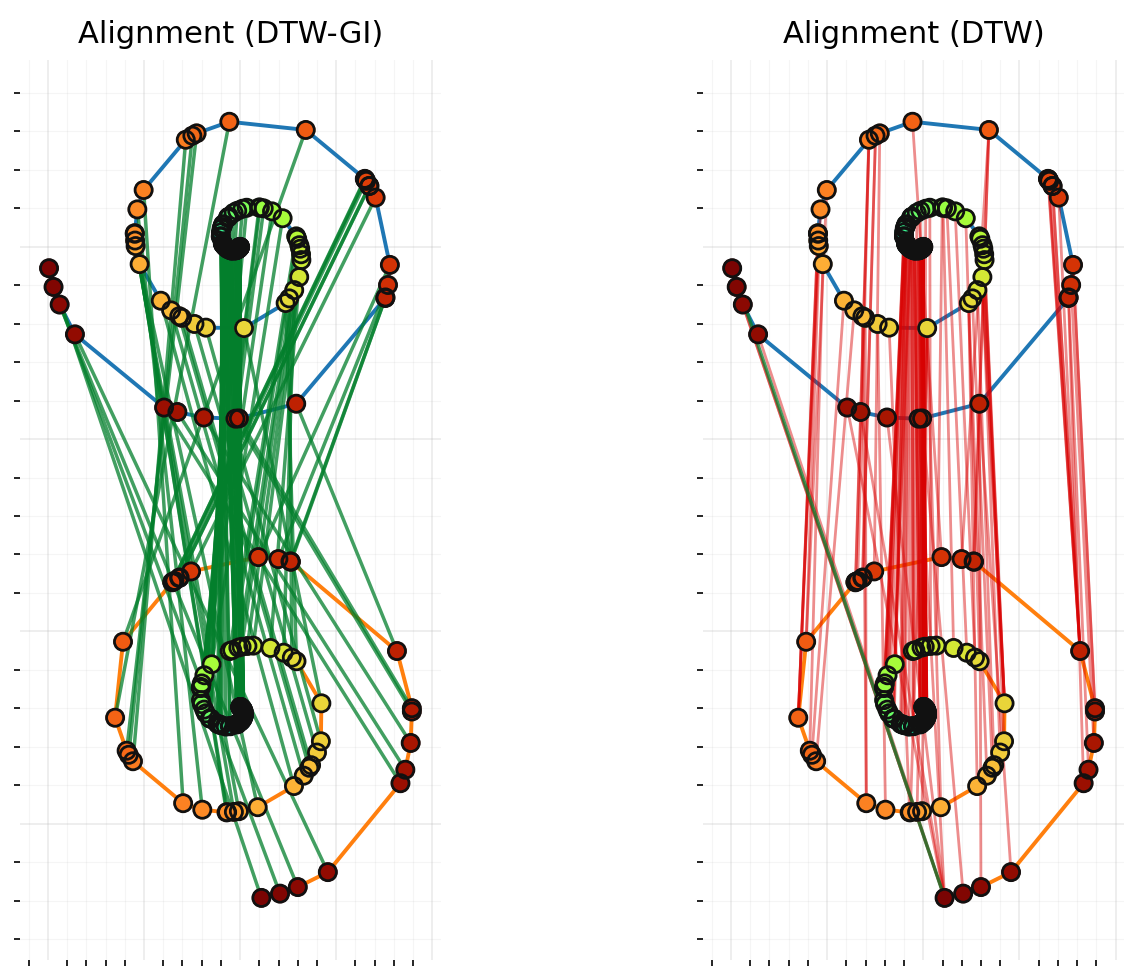

In [173]:
from data import plot_trajectory, make_one_spiral
x = make_one_spiral(sz=100, noise=0.0)
R1 = get_rot2d(np.pi / 3)
trajectory = x @ R1.T
rng = np.random.default_rng(0)
R = get_rot2d(np.pi/2)
y = trajectory @ R.T + 0.001 * rng.standard_normal(x.shape)

rotated_trajectory = y

path_dtw, _ = dtw_path(trajectory, rotated_trajectory)



path_gi = dtw_gi_multistart(trajectory, rotated_trajectory, max_iter=200, verbose = True).path

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

plot_correspondences_2d(
    axes[0], trajectory, rotated_trajectory, path_gi,
    title="Alignment (DTW-GI)",
    cmap_name="turbo"
)

plot_correspondences_2d(
    axes[1], trajectory, rotated_trajectory, path_dtw,
    title="Alignment (DTW)",
    cmap_name="turbo"
)

plt.tight_layout()
plt.show()